In [47]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [48]:
seed = 59 
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
PATH = '/Users/microwave/AIO_2024/Module_5/Week3/Auto_MPG_data.csv'
dataset = pd.read_csv(PATH)

In [50]:
X = dataset.drop(columns = 'MPG').values
y = dataset['MPG'].values

In [51]:
val_size = 0.2 
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= val_size, random_state=seed, shuffle=is_shuffle)
X_train,X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed, shuffle=is_shuffle)

In [52]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [53]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
        

In [54]:
BATCH_SIZE = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [61]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = F.tanh(x)
        x = self.linear2(x)
        x = F.tanh(x)
        out = self.output(x)
        return out.squeeze(1)

In [62]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [63]:
lr = 1e-2
loss_fn = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)
epochs = 100

In [64]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)

    mean_true = torch.mean(y_true)
    sst = torch.sum((y_true - mean_true)**2)
    ssr = torch.sum((y_true - y_pred)**2)
    r2 = 1 - (ssr/sst)
    return r2

In [65]:
def train(model, train_loader, val_loader, loss_fn, optim, epochs):
    train_losses = []
    val_losses = []
    train_r2 = []
    val_r2 = []

    for epoch in range(epochs):
        train_loss = 0.0
        train_target = []
        val_target = []
        train_predict = []
        val_predict = []

        model.train()

        for X_samples, y_samples in train_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            optim.zero_grad()
            outputs = model(X_samples)
            train_predict += outputs.tolist()
            train_target += y_samples.tolist()

            loss = loss_fn(outputs, y_samples)

            loss.backward()
            optim.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        train_r2.append(r_squared(train_target, train_predict))

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_samples, y_samples in val_loader:
                X_samples = X_samples.to(device)
                y_samples = y_samples.to(device)

                outputs = model(X_samples)
                val_predict += outputs.tolist()
                val_target += y_samples.tolist()

                loss = loss_fn(outputs, y_samples)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_r2.append(r_squared(val_target, val_predict))

        if epoch % 10 == 0:
            print(f'Epoch: {epoch+1}/{epochs} \\\\t| Train Loss: {train_loss:.3f} \\\\t| Train R2: {train_r2[-1]:.3f} \\\\t| Val Loss: {val_loss:.3f} \\\\t| Val R2: {val_r2[-1]:.3f}')

    print(f'Train Loss: {train_loss:.3f} \\\\t| Train R2: {train_r2[-1]:.3f} \\\\t| Val Loss: {val_loss:.3f} \\\\t| Val R2: {val_r2[-1]:.3f}')


    return train_losses, val_losses, train_r2, val_r2

train_losses, val_losses, train_r2, val_r2 = train(model, train_loader, val_loader, loss_fn, optim, epochs)

Epoch: 1/100 \\t| Train Loss: 242.334 \\t| Train R2: -3.287 \\t| Val Loss: 25.870 \\t| Val R2: 0.586
Epoch: 11/100 \\t| Train Loss: 9.226 \\t| Train R2: 0.854 \\t| Val Loss: 7.786 \\t| Val R2: 0.872
Epoch: 21/100 \\t| Train Loss: 7.023 \\t| Train R2: 0.878 \\t| Val Loss: 5.788 \\t| Val R2: 0.911
Epoch: 31/100 \\t| Train Loss: 7.251 \\t| Train R2: 0.876 \\t| Val Loss: 6.091 \\t| Val R2: 0.896
Epoch: 41/100 \\t| Train Loss: 5.874 \\t| Train R2: 0.900 \\t| Val Loss: 5.891 \\t| Val R2: 0.901
Epoch: 51/100 \\t| Train Loss: 6.361 \\t| Train R2: 0.898 \\t| Val Loss: 7.293 \\t| Val R2: 0.884
Epoch: 61/100 \\t| Train Loss: 5.685 \\t| Train R2: 0.902 \\t| Val Loss: 5.525 \\t| Val R2: 0.902
Epoch: 71/100 \\t| Train Loss: 5.323 \\t| Train R2: 0.910 \\t| Val Loss: 4.823 \\t| Val R2: 0.912
Epoch: 81/100 \\t| Train Loss: 5.408 \\t| Train R2: 0.907 \\t| Val Loss: 5.586 \\t| Val R2: 0.912
Epoch: 91/100 \\t| Train Loss: 4.684 \\t| Train R2: 0.921 \\t| Val Loss: 5.191 \\t| Val R2: 0.916
Train Loss: 4.588

In [67]:
def eval(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_target = []
    test_predict = []

    with torch.no_grad():
        for X_samples, y_samples in test_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            test_predict += outputs.tolist()
            test_target += y_samples.tolist()

            loss = loss_fn(outputs, y_samples)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_r2 = r_squared(test_target, test_predict)

    print(f'Test Loss: {test_loss:.3f} \\\\t| Test R2: {test_r2:.3f}')

    return test_loss, test_r2

test_loss, test_r2 = eval(model, test_loader)

Test Loss: 7.550 \\t| Test R2: 0.898


# Classification

In [68]:
seed = 59 
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [69]:
PATH = '/Users/microwave/AIO_2024/Module_5/Week3/NonLinear_data.npy'
data = np.load(PATH, allow_pickle=True).item()

X,y = data['X'], data['labels']
print(X.shape, y.shape)

(300, 2) (300,)


In [70]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [71]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 210
Number of val samples: 60
Number of test samples: 30


In [72]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [73]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [74]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [97]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP,self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        out = self.output(x)
        return out

In [104]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 512

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [105]:
lr = 1e-1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
epochs = 100

In [106]:
def compute_accuracy(y_hat, y):
    _, y_hat = torch.max(y_hat, dim = 1)
    correct = (y_hat == y).sum().item()
    acc = correct / len(y)
    return acc


In [107]:
def train(model, train_loader, val_loader, loss_fn, optim, epochs):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        train_loss = 0.0
        train_target = []
        train_predict = []
        model.train()

        for X_samples, y_samples in train_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            
            outputs = model(X_samples)
            optim.zero_grad()
            loss = loss_fn(outputs, y_samples)
            loss.backward()
            optim.step()

            train_loss += loss.item()

            train_predict.append(outputs.detach().cpu())
            train_target.append(y_samples.cpu())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        train_predict = torch.cat(train_predict)
        train_target = torch.cat(train_target)
        train_acc = compute_accuracy(train_predict, train_target)
        train_accs.append(train_acc)

        val_loss = 0.0
        val_target = []
        val_predict = []

        model.eval()

        with torch.no_grad():
            for X_samples, y_samples in val_loader:
                X_samples = X_samples.to(device)
                y_samples = y_samples.to(device)

                outputs = model(X_samples)
                val_loss += loss_fn(outputs, y_samples).item()

                val_predict.append(outputs.cpu())
                val_target.append(y_samples.cpu())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch+1}/{epochs} \t| Train Loss: {train_loss:.3f} \t| Train Acc: {train_acc:.3f} \t| Val Loss: {val_loss:.3f} \t| Val Acc: {val_acc:.3f}')

    print(f'Train Loss: {train_loss:.3f} \t| Train Acc: {train_acc:.3f} \t| Val Loss: {val_loss:.3f} \t| Val Acc: {val_acc:.3f}')

    return train_losses, val_losses, train_accs, val_accs 

train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, loss_fn, optimizer, epochs)

Epoch: 1/100 	| Train Loss: 0.794 	| Train Acc: 0.595 	| Val Loss: 1.081 	| Val Acc: 0.483
Epoch: 11/100 	| Train Loss: 0.652 	| Train Acc: 0.690 	| Val Loss: 0.921 	| Val Acc: 0.667
Epoch: 21/100 	| Train Loss: 0.560 	| Train Acc: 0.700 	| Val Loss: 0.711 	| Val Acc: 0.633
Epoch: 31/100 	| Train Loss: 0.489 	| Train Acc: 0.738 	| Val Loss: 0.616 	| Val Acc: 0.650
Epoch: 41/100 	| Train Loss: 0.353 	| Train Acc: 0.871 	| Val Loss: 0.429 	| Val Acc: 0.800
Epoch: 51/100 	| Train Loss: 0.329 	| Train Acc: 0.876 	| Val Loss: 0.339 	| Val Acc: 0.817
Epoch: 61/100 	| Train Loss: 0.261 	| Train Acc: 0.933 	| Val Loss: 0.348 	| Val Acc: 0.900
Epoch: 71/100 	| Train Loss: 0.226 	| Train Acc: 0.929 	| Val Loss: 0.258 	| Val Acc: 0.900
Epoch: 81/100 	| Train Loss: 0.210 	| Train Acc: 0.924 	| Val Loss: 0.317 	| Val Acc: 0.850
Epoch: 91/100 	| Train Loss: 0.203 	| Train Acc: 0.938 	| Val Loss: 0.209 	| Val Acc: 0.950
Train Loss: 0.166 	| Train Acc: 0.943 	| Val Loss: 0.217 	| Val Acc: 0.883


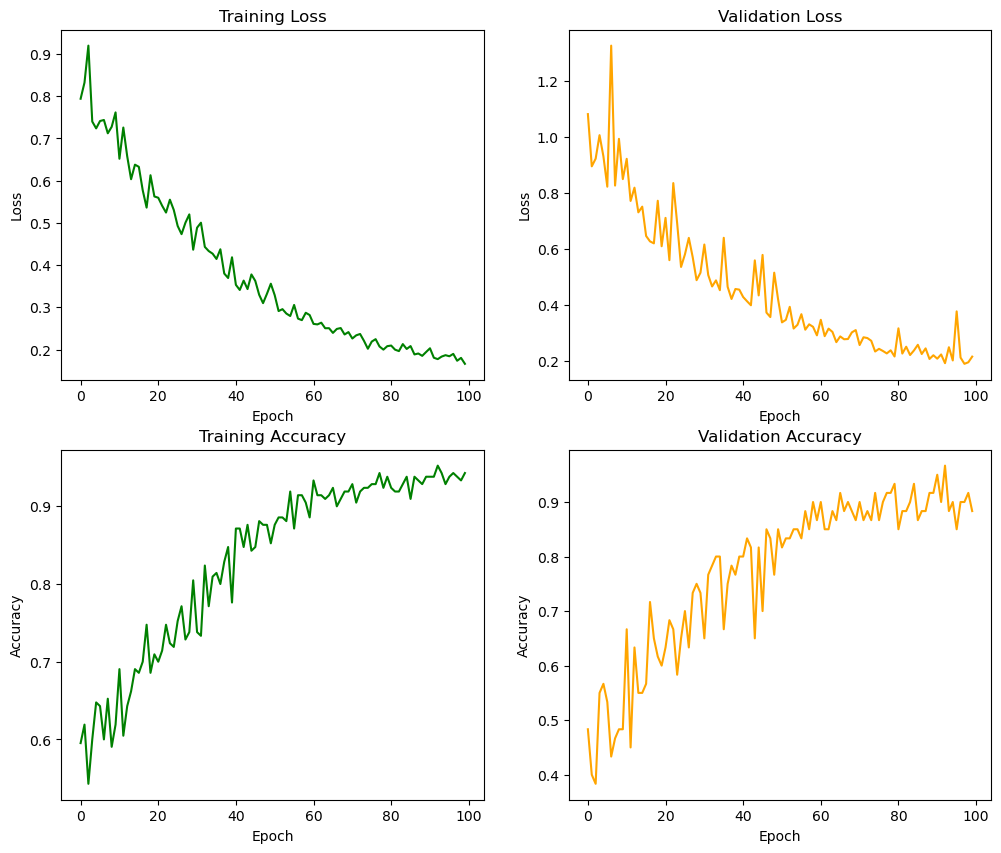

In [108]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [110]:
def eval(val_loader,model):
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)

        print('Evaluation on val set:')
        print(f'Accuracy: {val_acc}')
    return val_acc

eval(val_loader, model)

Evaluation on val set:
Accuracy: 0.8833333333333333


0.8833333333333333

In [111]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [112]:
random_state = 59 
np.random.seed(random_state)
torch.manual_seed(random_state)

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [113]:
train_dir = '/Users/microwave/AIO_2024/Module_5/Week3/FER-2013/train'
test_dir = '/Users/microwave/AIO_2024/Module_5/Week3/FER-2013/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx,cls in enumerate(classes)}
idx2label = {idx:cls for cls,idx in label2idx.items()}

Width: 48, Height: 48


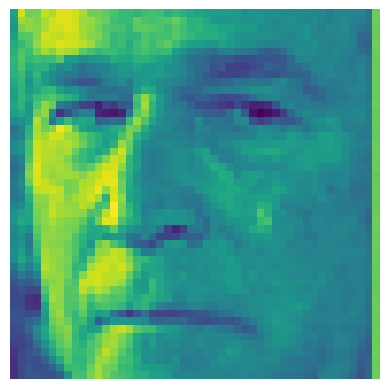

In [114]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


folder_path = '/Users/microwave/AIO_2024/Module_5/Week3/FER-2013/train/sad'

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
sample_image = random.choice(image_files)
image_path = os.path.join(folder_path, sample_image)
image = Image.open(image_path)

# Get image dimensions
width, height = image.size
print(f"Width: {width}, Height: {height}")

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [115]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split = 'train', train_ratio = 0.8):
        # self.resize = Resize((img_height, img_width))
        self.resize = Resize((128, 128))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir 
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train','val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size = train_ratio,
                random_state = random_state,
                stratify = self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1

        return img, label

In [118]:
BATCH_SIZE = 256

train_dataset = ImageDataset(
    img_dir = train_dir,
    norm = False,
    label2idx = label2idx,
    split = 'train'
)


val_dataset = ImageDataset(
    img_dir = train_dir,
    norm = False,
    label2idx = label2idx,
    split = 'val'
)

test_dataset = ImageDataset(
    img_dir = test_dir,
    norm = False,
    label2idx = label2idx,
    split = 'test'
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

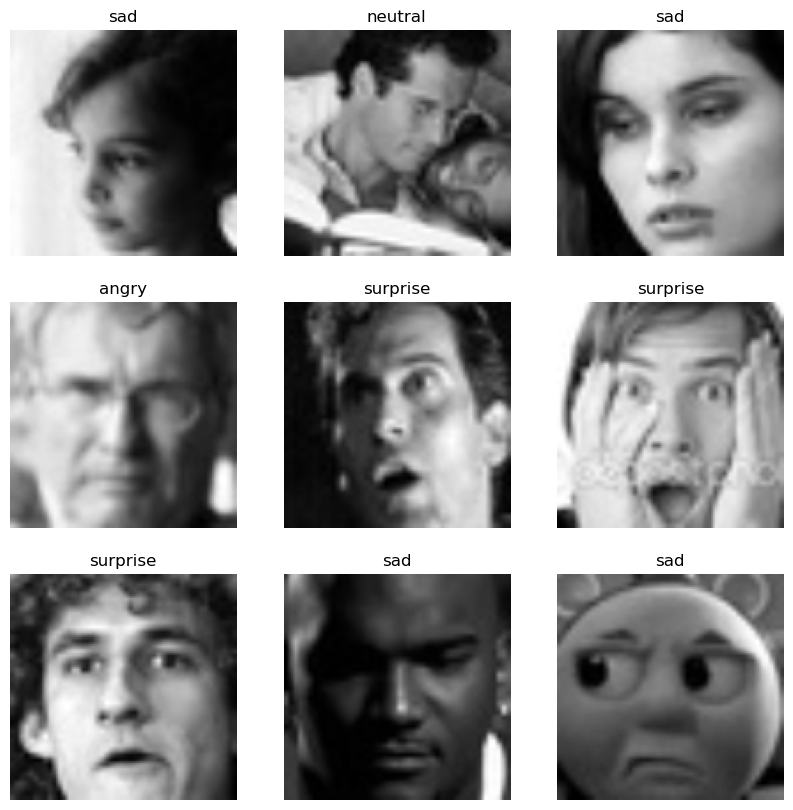

In [119]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize = (10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()) , vmin =minv ,vmax =maxv,cmap ="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis('off')

In [120]:
class ImageMLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims,hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims *2)
        self.linear3 = nn.Linear(hidden_dims *2,hidden_dims)
        self.output = nn.Linear(hidden_dims,output_dims)

    def forward(self,x):
        # print(x.shape)  # Add this line to print the input shape
        x = nn.Flatten(start_dim=1)(x)  # -> [256, 16384]
        x = self.linear1(x)             # -> [256, 256]
        x = F.relu(x)
        x = self.linear2(x)             # -> [256, 128]
        x = F.relu(x)
        x = self.linear3(x)             # -> [256, 64]
        x = F.relu(x)
        out = self.output(x)            # -> [256, 7]
        return out.squeeze(1)           # -> [256, 7]

In [121]:
input_dims = 128 * 128
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = ImageMLP(input_dims=input_dims,hidden_dims=hidden_dims, output_dims=output_dims).to(device)

In [122]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)
epochs = 40

In [123]:
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break  # Just check first batch

Batch images shape: torch.Size([256, 1, 128, 128])
Batch labels shape: torch.Size([256])


In [124]:
print(model) 

ImageMLP(
  (linear1): Linear(in_features=16384, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=7, bias=True)
)


In [125]:
def train(model, train_loader, val_loader, loss_fn, optim, epochs, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_target = []
        train_predict = []

        for batch_idx, (X_samples, y_samples) in enumerate(train_loader):
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            
            outputs = model(X_samples)
            loss = loss_fn(outputs, y_samples)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            train_loss += loss.item()
            
            train_predict.append(outputs.detach().cpu())
            train_target.append(y_samples.cpu())
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        train_predict = torch.cat(train_predict)
        train_target = torch.cat(train_target)
        train_acc = compute_accuracy(train_predict, train_target)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_target = []
        val_predict = []

        with torch.no_grad():
            for batch_idx, (X_samples, y_samples) in enumerate(val_loader):
                X_samples = X_samples.to(device)
                y_samples = y_samples.to(device)
                
                outputs = model(X_samples)
                loss = loss_fn(outputs, y_samples)
                
                val_loss += loss.item()

                val_predict.append(outputs.cpu())
                val_target.append(y_samples.cpu())
                
                if (batch_idx + 1) % 100 == 0:
                    print(f'Validation Batch {batch_idx+1}/{len(val_loader)} - Loss: {loss.item():.4f}')

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)

        # Logging
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}] | '
                  f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | '
                  f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}')


    print(f'Final Epoch | 'f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | 'f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs

train_losses, val_losses, train_accs, val_accs = train(
    model, train_loader, val_loader, loss_fn, optimizer, epochs, device
)


Epoch [1/40] | Train Loss: 344.5580 | Train Acc: 0.1911 | Val Loss: 1.8862 | Val Acc: 0.2511
Epoch [10/40] | Train Loss: 1.8099 | Train Acc: 0.2512 | Val Loss: 1.8074 | Val Acc: 0.2516
Epoch [20/40] | Train Loss: 1.8098 | Train Acc: 0.2515 | Val Loss: 1.8072 | Val Acc: 0.2518


KeyboardInterrupt: 

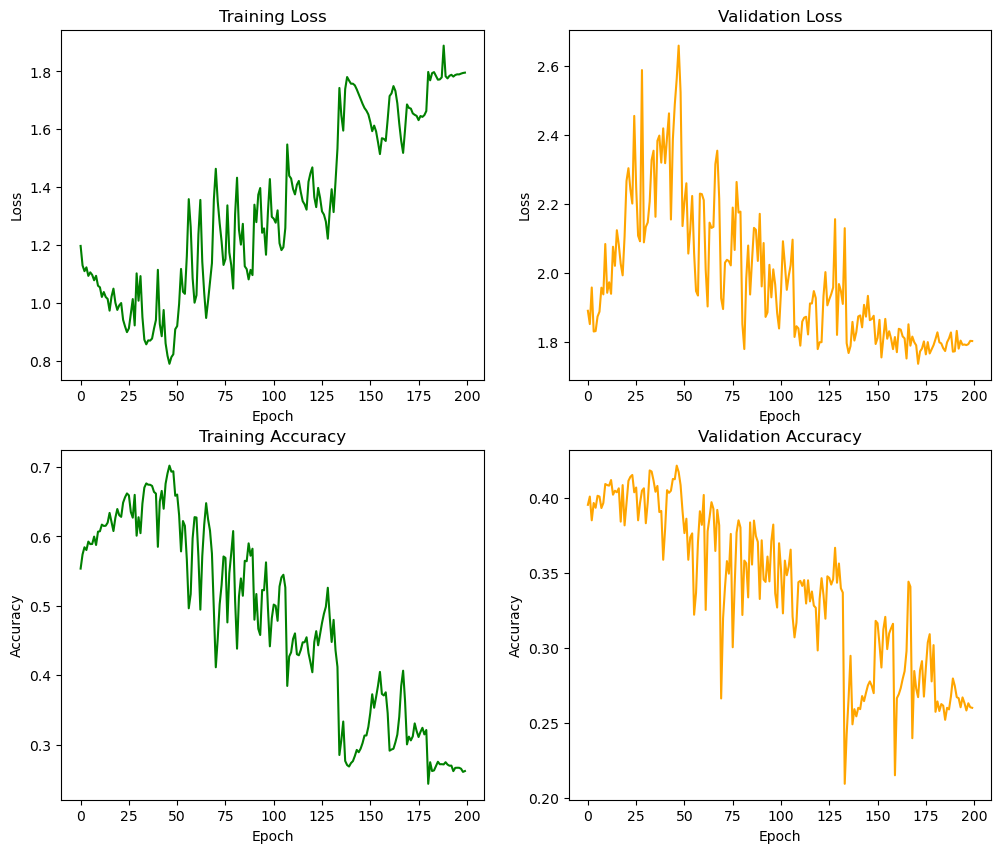

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
eval(test_loader, model)

NameError: name 'test_loader' is not defined